# Basic Emotional Theory

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from numpy import log
import plotly.express as px

In [3]:
#Importing data
df = pd.read_csv("EmoTag1200-scores.csv")
df.head()
#Quite a few zero values present- I would ideally like to adjust them to non-zero probabilities if possible

,unicode,emoji,name,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,1F308,🌈,rainbow,0.00,0.28,0.00,0.00,0.69,0.06,0.22,0.33
1,1F319,🌙,crescent moon,0.00,0.31,0.00,0.00,0.25,0.00,0.06,0.25
2,1F31A,🌚,new moon face,0.06,0.08,0.17,0.06,0.42,0.19,0.06,0.11
3,1F31E,🌞,sun with face,0.00,0.22,0.00,0.00,0.78,0.00,0.11,0.22
4,1F31F,🌟,glowing star,0.00,0.28,0.00,0.00,0.53,0.00,0.25,0.31


In [4]:
#Check how frequent the value zero is in the dataset
zero_count = (df == 0).sum().sum()

#Print the occurrences
print("Number of occurrences of 0:", zero_count)

#There are a very significant number of zeros

Number of occurrences of 0: 351


In [5]:
#Check zero probability frequency in each column separately
zero_count_by_column = (df == 0).sum(axis=0)

#Print the occurrences by column
print("Count of occurrences of 0 by column:")
print(zero_count_by_column)

#It occurs more in the negative emotions than positive
#Needs to be addressed otherwise the data for negative emojis will be very sparse leading to issues in generalisation

Count of occurrences of 0 by column:
unicode          0
emoji            0
name             0
anger           75
anticipation     0
disgust         77
fear            68
joy             34
sadness         71
surprise        19
trust            7
dtype: int64


In [6]:
df.shape

(150, 11)

In [7]:
df.isnull().sum()
#Data is whole

unicode         0
emoji           0
name            0
anger           0
anticipation    0
disgust         0
fear            0
joy             0
sadness         0
surprise        0
trust           0
dtype: int64

In [8]:
#Quality check the data

#Check that the sum of the basic emotion ratings are equal to 1
count = 0

#Iterate over each row
for index, row in df.iterrows():
    #Check if the sum of basic emotion columns is not equal to the total column for the current row
    if row['anger'] + row['anticipation'] + row['disgust'] + row['fear'] + row['joy'] + row['sadness'] + row['surprise'] + row['trust'] != 1:
        #Increment the counter if the condition is not satisfied
        count += 1

#Print the count of rows where the condition is not satisfied
print("Number of rows where the sum is not equal to total occurrences:", count)

#This is not the case for any rows- may need to be normalised

Number of rows where the sum is not equal to total occurrences: 150


In [9]:
#Create a column that adds the total values for all basic emotions
df['total'] = df['anger'] + df['anticipation'] + df['disgust'] + df['fear'] + df['joy'] + df['sadness'] + df['surprise'] + df['trust']

df.head()
#Values are very different- normalisation may not be valid in this context
#It is possible that the rainbow ilicits an overall greater emotional reaction that the crescent moon

,unicode,emoji,name,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,total
0,1F308,🌈,rainbow,0.00,0.28,0.00,0.00,0.69,0.06,0.22,0.33,1.58
1,1F319,🌙,crescent moon,0.00,0.31,0.00,0.00,0.25,0.00,0.06,0.25,0.87
2,1F31A,🌚,new moon face,0.06,0.08,0.17,0.06,0.42,0.19,0.06,0.11,1.15
3,1F31E,🌞,sun with face,0.00,0.22,0.00,0.00,0.78,0.00,0.11,0.22,1.33
4,1F31F,🌟,glowing star,0.00,0.28,0.00,0.00,0.53,0.00,0.25,0.31,1.37


In [10]:
df['total'].mean(), df['total'].median()

(1.5564666666666667, 1.625)

In [11]:
df.describe()
#Some emojis give rise to up three times the emotional response than others (at the most extreme ends)

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,total
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,0.109200,0.280667,0.128333,0.126133,0.346867,0.133333,0.176267,0.255667,1.556467
std,0.180861,0.133108,0.192010,0.197796,0.314143,0.227232,0.157103,0.196340,0.621799
min,0.000000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.110000
25%,0.000000,0.190000,0.000000,0.000000,0.030000,0.000000,0.060000,0.110000,1.162500
50%,0.015000,0.280000,0.000000,0.060000,0.280000,0.030000,0.170000,0.220000,1.625000
75%,0.140000,0.360000,0.185000,0.140000,0.632500,0.140000,0.250000,0.360000,1.977500
max,1.000000,0.810000,0.670000,0.970000,1.000000,1.000000,0.890000,0.830000,3.150000


In [12]:
#Check for duplication in row identifiers
df['emoji'].is_unique

True

# Exploratory Analysis

Due to the sparsity within the data (quite a large quantity of zero-probabilities. It will be necessary to populate these values with values, while maintaining as much as possible the nuance of emotions within each emoji. Multiple smoothing methods can be used which will achieve this to varying degrees of sucess however prior to implementation it is important to have a clear understanding of the patterns in the data prior to smoothing. This insight ensures that good judgement can be applied when deciding if the patterns found in the data have been retained or altered more than is acceptable. This section of code aims to gain a deeper understanding of the data as it presently stands to facilitate the cleaning and pre-processing of the data in addition to later steps and interpretation of results. 

In [13]:
#Basic emotional theory dataset
df = pd.read_csv("EmoTag1200-scores.csv")
df.head()

,unicode,emoji,name,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,1F308,🌈,rainbow,0.00,0.28,0.00,0.00,0.69,0.06,0.22,0.33
1,1F319,🌙,crescent moon,0.00,0.31,0.00,0.00,0.25,0.00,0.06,0.25
2,1F31A,🌚,new moon face,0.06,0.08,0.17,0.06,0.42,0.19,0.06,0.11
3,1F31E,🌞,sun with face,0.00,0.22,0.00,0.00,0.78,0.00,0.11,0.22
4,1F31F,🌟,glowing star,0.00,0.28,0.00,0.00,0.53,0.00,0.25,0.31


In [15]:
#Import dimensional theory dataset
df1 = pd.read_csv("Dimensional_Theory.csv")
df1.head()

,Emoji,Unicode codepoint,Occurrences,Position,Unicode name,Unicode block,le_+,le_-,le_0,sent_score,sent_score_class,upper_error_class,lower_error_class,LogOccurrences,sent_polar
0,😂,0x1f602,14622,0.805101,FACE WITH TEARS OF JOY,Emoticons,0.468103,0.247179,0.284718,0.220923,Positive,Positive,Positive,9.590283,Positive
1,❤,0x2764,8050,0.746943,HEAVY BLACK HEART,Dingbats,0.790016,0.044207,0.165777,0.745809,Positive,Positive,Positive,8.993427,Positive
2,♥,0x2665,7144,0.753806,BLACK HEART SUIT,Miscellaneous Symbols,0.692738,0.035399,0.271862,0.657339,Positive,Positive,Positive,8.874028,Positive
3,😍,0x1f60d,6359,0.765292,SMILING FACE WITH HEART-SHAPED EYES,Emoticons,0.729488,0.051870,0.218642,0.677617,Positive,Positive,Positive,8.757626,Positive
4,😭,0x1f62d,5526,0.803352,LOUDLY CRYING FACE,Emoticons,0.343100,0.436426,0.220474,-0.093326,Neutral,Neutral,Neutral,8.617220,Negative


In [16]:
#Standardise the unicode codepoint formats for the two datasets

#Remove the "0x" prefix
df1["Unicode codepoint"] = df1["Unicode codepoint"].str.replace("0x", "")

# Convert letters to uppercase
df1["Unicode codepoint"] = df1["Unicode codepoint"].str.upper()

df1.head()

,Emoji,Unicode codepoint,Occurrences,Position,Unicode name,Unicode block,le_+,le_-,le_0,sent_score,sent_score_class,upper_error_class,lower_error_class,LogOccurrences,sent_polar
0,😂,1F602,14622,0.805101,FACE WITH TEARS OF JOY,Emoticons,0.468103,0.247179,0.284718,0.220923,Positive,Positive,Positive,9.590283,Positive
1,❤,2764,8050,0.746943,HEAVY BLACK HEART,Dingbats,0.790016,0.044207,0.165777,0.745809,Positive,Positive,Positive,8.993427,Positive
2,♥,2665,7144,0.753806,BLACK HEART SUIT,Miscellaneous Symbols,0.692738,0.035399,0.271862,0.657339,Positive,Positive,Positive,8.874028,Positive
3,😍,1F60D,6359,0.765292,SMILING FACE WITH HEART-SHAPED EYES,Emoticons,0.729488,0.051870,0.218642,0.677617,Positive,Positive,Positive,8.757626,Positive
4,😭,1F62D,5526,0.803352,LOUDLY CRYING FACE,Emoticons,0.343100,0.436426,0.220474,-0.093326,Neutral,Neutral,Neutral,8.617220,Negative


In [17]:
#Check that the unicode formats are the same for both now

#Define emoji to be searched
search_string = '1F602'

#Identify rows containing that codepoint
rows = df["unicode"].str.contains(search_string, case=False)
matched_rows = df[rows]
rows1 = df1["Unicode codepoint"].str.contains(search_string, case=False)
matched_rows1 = df1[rows1]

#Show results for- results look ok
matched_rows.head(), matched_rows1.head()

(   unicode emoji                    name  anger  anticipation  disgust  fear   
 67   1F602     😂  face with tears of joy    0.0          0.17     0.06  0.06  \
 
      joy  sadness  surprise  trust  
 67  0.94      0.0      0.33   0.22  ,
   Emoji Unicode codepoint  Occurrences  Position            Unicode name   
 0     😂             1F602        14622  0.805101  FACE WITH TEARS OF JOY  \
 
   Unicode block      le_+      le_-      le_0  sent_score sent_score_class   
 0     Emoticons  0.468103  0.247179  0.284718    0.220923         Positive  \
 
   upper_error_class lower_error_class  LogOccurrences sent_polar  
 0          Positive          Positive        9.590283   Positive  )

In [18]:
#Merge parameters from dimensional theory dataset to use in EDA

#Rename column in dimensional dataset to facilitate merging
df1.rename(columns={"Unicode codepoint": "unicode"}, inplace=True)

# Perform an inner merge
df = df.merge(df1, on="unicode", how="inner")

df.head()

,unicode,emoji,name,anger,anticipation,disgust,fear,joy,sadness,surprise,...,Unicode block,le_+,le_-,le_0,sent_score,sent_score_class,upper_error_class,lower_error_class,LogOccurrences,sent_polar
0,1F308,🌈,rainbow,0.00,0.28,0.00,0.00,0.69,0.06,0.22,...,Miscellaneous Symbols and Pictographs,0.582418,0.065934,0.351648,0.516484,Positive,Positive,Positive,4.477337,Positive
1,1F319,🌙,crescent moon,0.00,0.31,0.00,0.00,0.25,0.00,0.06,...,Miscellaneous Symbols and Pictographs,0.655738,0.065574,0.278689,0.590164,Positive,Positive,Positive,4.060443,Positive
2,1F31A,🌚,new moon face,0.06,0.08,0.17,0.06,0.42,0.19,0.06,...,Miscellaneous Symbols and Pictographs,0.622517,0.158940,0.218543,0.463576,Positive,Positive,Positive,4.997212,Positive
3,1F31E,🌞,sun with face,0.00,0.22,0.00,0.00,0.78,0.00,0.11,...,Miscellaneous Symbols and Pictographs,0.581818,0.024242,0.393939,0.557576,Positive,Positive,Positive,5.087596,Positive
4,1F31F,🌟,glowing star,0.00,0.28,0.00,0.00,0.53,0.00,0.25,...,Miscellaneous Symbols and Pictographs,0.386139,0.059406,0.554455,0.326733,Positive,Positive,Positive,5.293305,Positive


In [19]:
#I lost one emoji in the process- that is ok for the moment
df.shape

(149, 25)

In [20]:
#Check the columns so unnecessary ones can be removed
df.columns

Index(['unicode', 'emoji', 'name', 'anger', 'anticipation', 'disgust', 'fear',
       'joy', 'sadness', 'surprise', 'trust', 'Emoji', 'Occurrences',
       'Position', 'Unicode name', 'Unicode block', 'le_+', 'le_-', 'le_0',
       'sent_score', 'sent_score_class', 'upper_error_class',
       'lower_error_class', 'LogOccurrences', 'sent_polar'],
      dtype='object')

In [21]:
#Remove unnecessary columns
df = df.drop(columns=['name', 'Emoji', 'Occurrences', 'Unicode name', 'LogOccurrences'])
df.head()

,unicode,emoji,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,Position,Unicode block,le_+,le_-,le_0,sent_score,sent_score_class,upper_error_class,lower_error_class,sent_polar
0,1F308,🌈,0.00,0.28,0.00,0.00,0.69,0.06,0.22,0.33,0.671884,Miscellaneous Symbols and Pictographs,0.582418,0.065934,0.351648,0.516484,Positive,Positive,Positive,Positive
1,1F319,🌙,0.00,0.31,0.00,0.00,0.25,0.00,0.06,0.25,0.669390,Miscellaneous Symbols and Pictographs,0.655738,0.065574,0.278689,0.590164,Positive,Positive,Positive,Positive
2,1F31A,🌚,0.06,0.08,0.17,0.06,0.42,0.19,0.06,0.11,0.759895,Miscellaneous Symbols and Pictographs,0.622517,0.158940,0.218543,0.463576,Positive,Positive,Positive,Positive
3,1F31E,🌞,0.00,0.22,0.00,0.00,0.78,0.00,0.11,0.22,0.709366,Miscellaneous Symbols and Pictographs,0.581818,0.024242,0.393939,0.557576,Positive,Positive,Positive,Positive
4,1F31F,🌟,0.00,0.28,0.00,0.00,0.53,0.00,0.25,0.31,0.654511,Miscellaneous Symbols and Pictographs,0.386139,0.059406,0.554455,0.326733,Positive,Positive,Positive,Positive


In [22]:
#Create a column showing the primary basic emotion- one which has the greatest value

#Specify the columns to consider
basic_emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

#Create a new column with the name of the column containing the maximum value
df['primary_basic_emot'] = df[basic_emotions].idxmax(axis=1)
df.head()

,unicode,emoji,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,...,Unicode block,le_+,le_-,le_0,sent_score,sent_score_class,upper_error_class,lower_error_class,sent_polar,primary_basic_emot
0,1F308,🌈,0.00,0.28,0.00,0.00,0.69,0.06,0.22,0.33,...,Miscellaneous Symbols and Pictographs,0.582418,0.065934,0.351648,0.516484,Positive,Positive,Positive,Positive,joy
1,1F319,🌙,0.00,0.31,0.00,0.00,0.25,0.00,0.06,0.25,...,Miscellaneous Symbols and Pictographs,0.655738,0.065574,0.278689,0.590164,Positive,Positive,Positive,Positive,anticipation
2,1F31A,🌚,0.06,0.08,0.17,0.06,0.42,0.19,0.06,0.11,...,Miscellaneous Symbols and Pictographs,0.622517,0.158940,0.218543,0.463576,Positive,Positive,Positive,Positive,joy
3,1F31E,🌞,0.00,0.22,0.00,0.00,0.78,0.00,0.11,0.22,...,Miscellaneous Symbols and Pictographs,0.581818,0.024242,0.393939,0.557576,Positive,Positive,Positive,Positive,joy
4,1F31F,🌟,0.00,0.28,0.00,0.00,0.53,0.00,0.25,0.31,...,Miscellaneous Symbols and Pictographs,0.386139,0.059406,0.554455,0.326733,Positive,Positive,Positive,Positive,joy


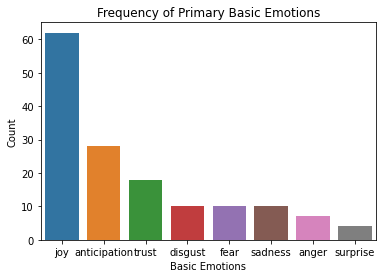

In [23]:
#Create a plot to look at distribution of the primary basic emotions
sns.countplot(x=df['primary_basic_emot'])

#Add labels and title
plt.xlabel('Basic Emotions')
plt.ylabel('Count')
plt.title('Frequency of Primary Basic Emotions')
plt.show()

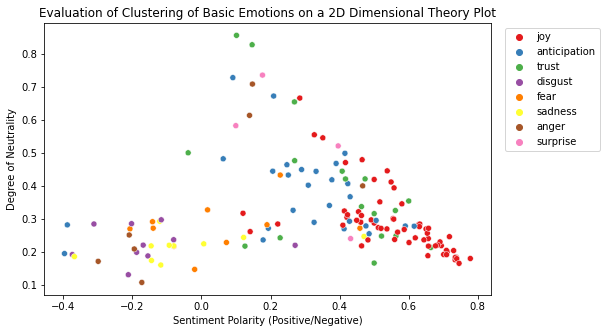

In [24]:
#Create scatter plot to evaluate potential clustering of primary basic emotions on a dimensional theory plot

#Define parameters
x = df['sent_score'] 
y = df['le_0']  
emotion_categories = df['primary_basic_emot']

#Create a colour palette for the emotion categories
palette = sns.color_palette('Set1', n_colors=len(emotion_categories.unique()))

#Create the scatter plot
sns.scatterplot(x=x, y=y, hue=emotion_categories, palette=palette)

#Add aixs labels and title
plt.xlabel('Sentiment Polarity (Positive/Negative)')
plt.ylabel('Degree of Neutrality')
plt.title('Evaluation of Clustering of Basic Emotions on a 2D Dimensional Theory Plot')

#Define legend position
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

#Define plot size
plt.gcf().set_size_inches(8, 5) 

#Display the plot
plt.show()

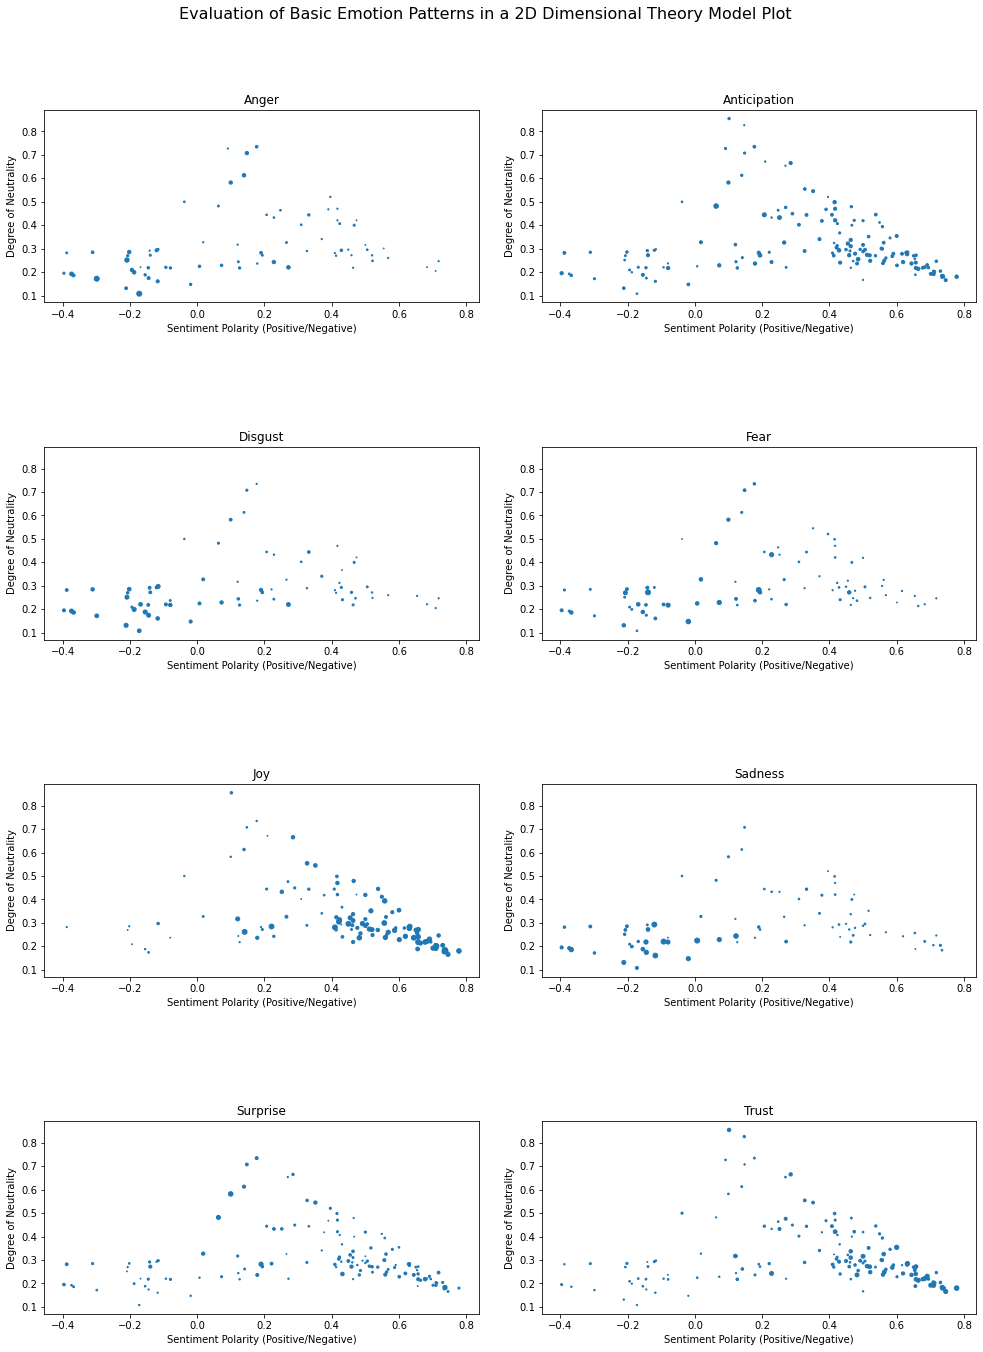

In [86]:
#Make a list of basic emotions
emotions = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]

#Define plot layout
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 8))

#Iterate over each emotion to define plot parameters
for emotion, ax in zip(emotions, axes.flatten()):
    x = df['sent_score'] 
    y = df['le_0']

    #Make marker size proportional to the degree of afinity to that emotion
    marker_size = df[emotion] * 25
    
    #Create the scatter plot
    ax.scatter(x, y, s=marker_size, alpha=1)

    #Set the title for each subplot
    ax.set_title(emotion.capitalize())

    #Add overall title
    fig.suptitle("Evaluation of Basic Emotion Patterns in a 2D Dimensional Theory Model Plot", fontsize=16)
    
    #Set axis labels
    ax.set_xlabel('Sentiment Polarity (Positive/Negative)')
    ax.set_ylabel('Degree of Neutrality')

#Adjust spacing between subplots
plt.tight_layout()

#Define plot size
plt.gcf().set_size_inches(14, 20) 

#Display the plot
plt.show()

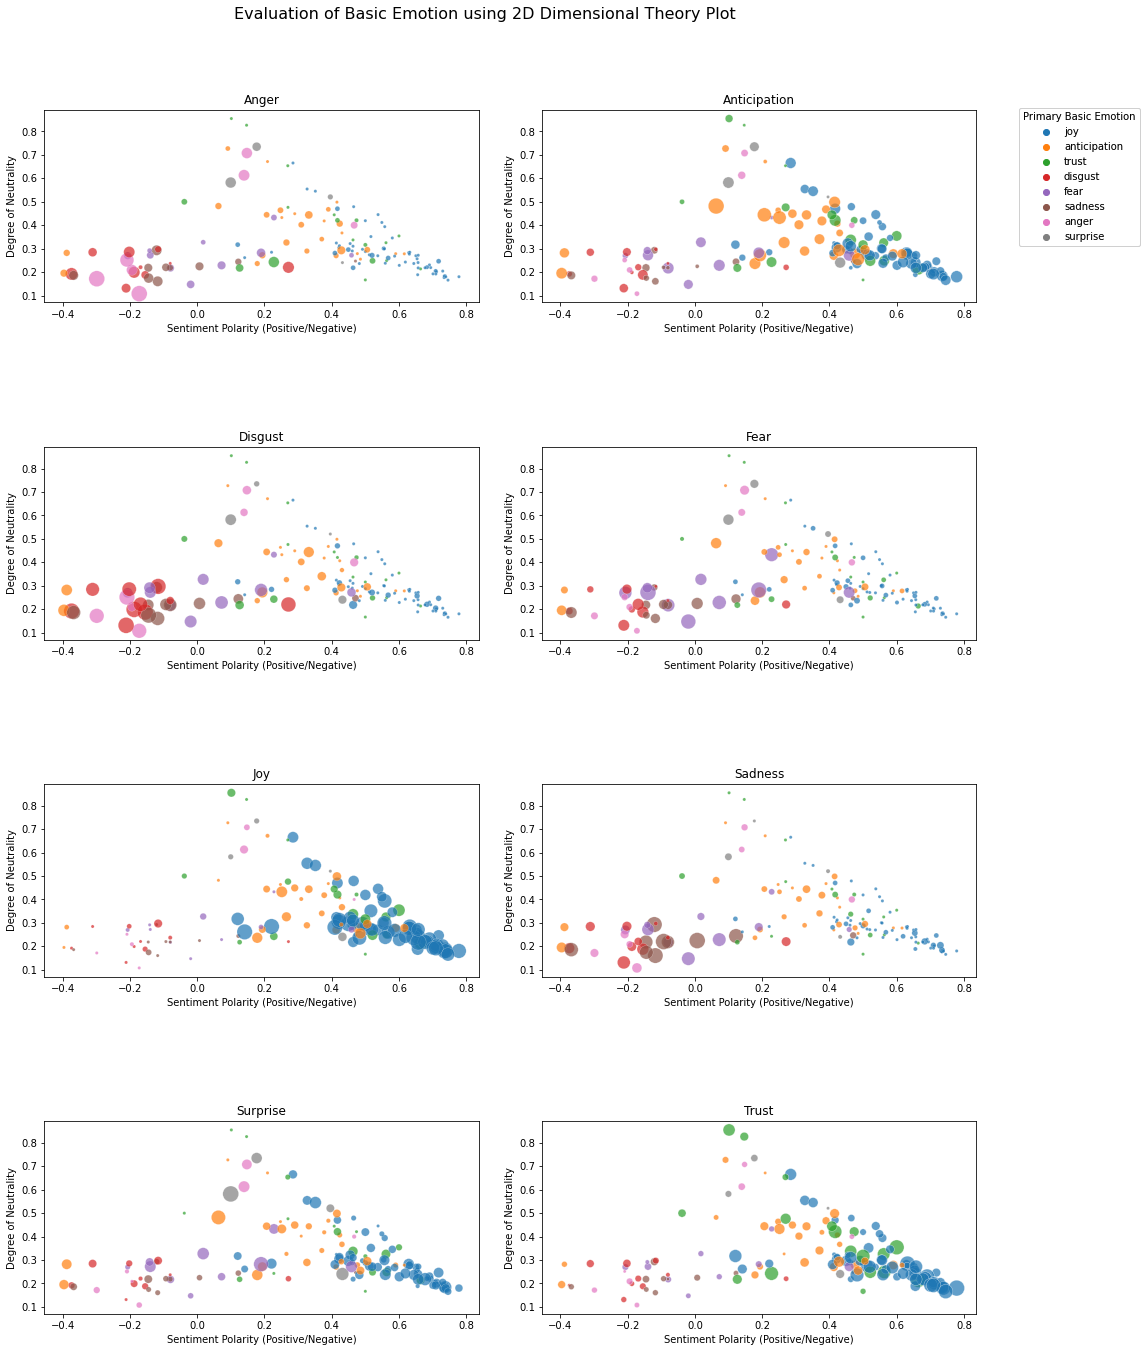

In [122]:
#Define plot layout
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 8))

#Lists to store legend handles and labels
legend_handles_color = []
legend_labels_color = []

#Iterate over each emotion to define plot parameters
for emotion, ax in zip(emotions, axes.flatten()):
    x = df['sent_score']
    y = df['le_0']

    #Make marker size proportional to the degree of affinity to that emotion
    marker_size = df[emotion] * 25

    #Create the scatter plot with hue as primary basic emotion
    sns.scatterplot(x=x, y=y, hue=df['primary_basic_emot'], size=marker_size, sizes=(10, 250), alpha=0.7, ax=ax)

    #Set the title for each subplot
    ax.set_title(emotion.capitalize())

    #Add overall title
    fig.suptitle("Evaluation of Basic Emotion using 2D Dimensional Theory Plot", fontsize=16)

    #Set axis labels
    ax.set_xlabel('Sentiment Polarity (Positive/Negative)')
    ax.set_ylabel('Degree of Neutrality')

    #Get the handles and labels for the color legend and add them to the lists
    handles_color, labels_color = ax.get_legend_handles_labels()
    legend_handles_color.extend(handles_color)
    legend_labels_color.extend(labels_color)

    #Remove size legend
    ax.get_legend().remove()

#Remove duplicates from the color legend
unique_handles_color, unique_labels_color = [], []
for handle_color, label_color in zip(legend_handles_color, legend_labels_color):
    if label_color in emotions and label_color not in unique_labels_color:  # Only include specified emotions in the legend
        unique_handles_color.append(handle_color)
        unique_labels_color.append(label_color)

#Create a custom color legend with only specified emotions labels
color_legend = fig.legend(handles=unique_handles_color, labels=unique_labels_color, bbox_to_anchor=(1.03, 0.91), loc='upper left', borderaxespad=0., title="Basic Emotion")

#Add the color legend to the plot
fig.add_artist(color_legend)

#Adjust spacing between subplots
plt.tight_layout()

#Define plot size
plt.gcf().set_size_inches(14, 20)

#Display the plot
plt.show()

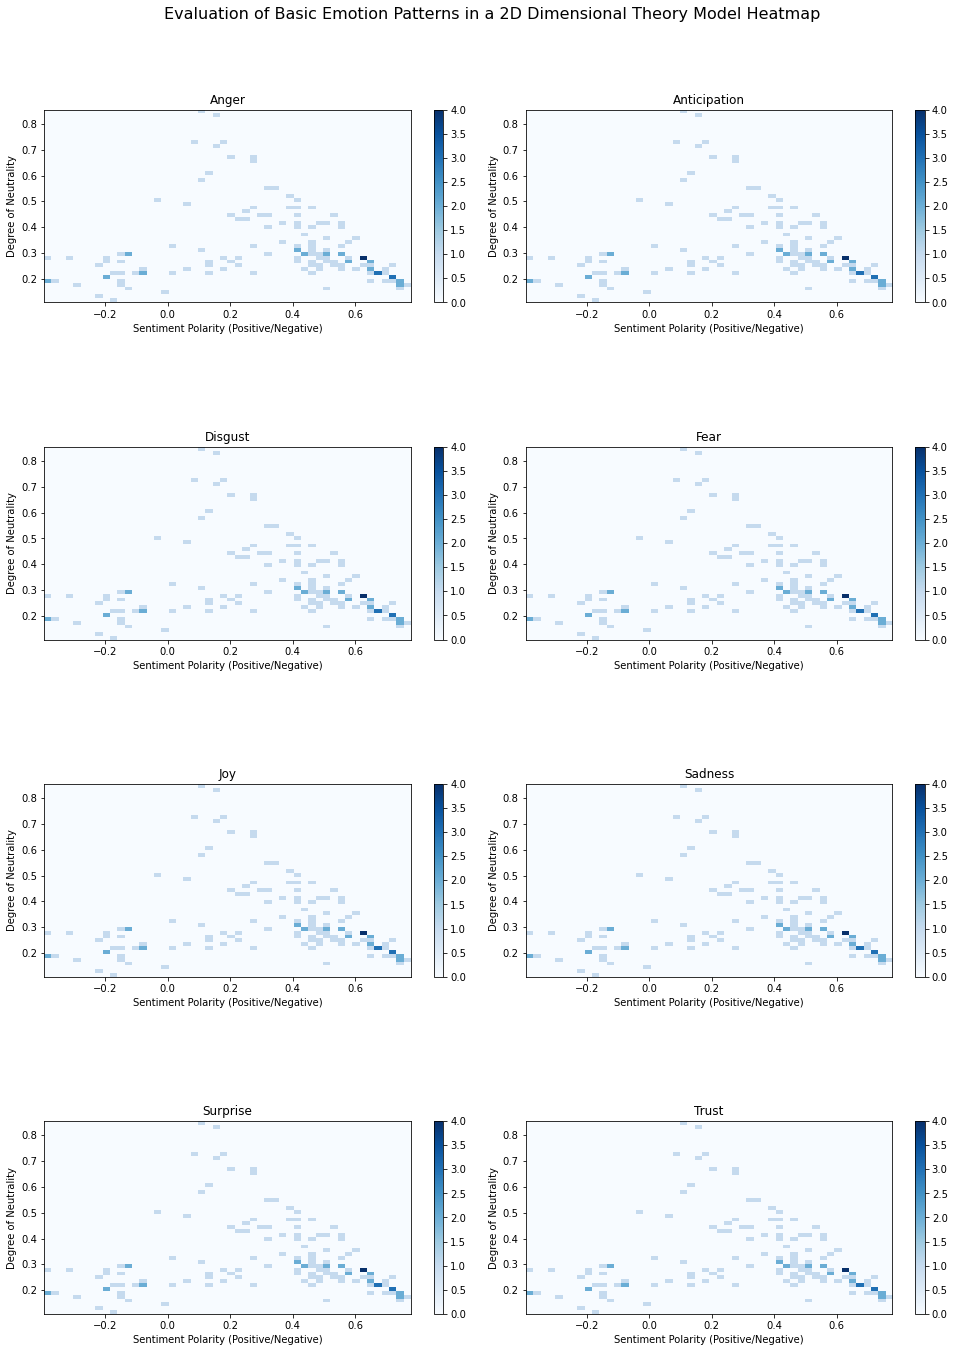

In [87]:
#Define plot layout
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 8))

#Iterate over each emotion to define plot parameters
for emotion, ax in zip(emotions, axes.flatten()):
    x = df['sent_score']
    y = df['le_0']

    #Create heatmap data using a 2D histogram
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    #Plot the heatmap
    im = ax.imshow(heatmap.T, extent=extent, origin='lower', cmap='Blues', aspect='auto')

    #Set the title for each subplot
    ax.set_title(emotion.capitalize())

    #Add overall title
    fig.suptitle("Evaluation of Basic Emotion Patterns in a 2D Dimensional Theory Model Heatmap", fontsize=16)

    #Set axis labels
    ax.set_xlabel('Sentiment Polarity (Positive/Negative)')
    ax.set_ylabel('Degree of Neutrality')

    #Add colorbar
    fig.colorbar(im, ax=ax)

#Adjust spacing between subplots
plt.tight_layout()

#Define plot size
plt.gcf().set_size_inches(14, 20)

#Display the plot
plt.show()

#Heatmap is not as effective as the previous plot as this plot shows data density but doesn't show relative affinity

In [85]:
#Check columns
df.columns

Index(['unicode', 'emoji', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'sadness', 'surprise', 'trust', 'Position', 'Unicode block', 'le_+',
       'le_-', 'le_0', 'sent_score', 'sent_score_class', 'upper_error_class',
       'lower_error_class', 'sent_polar', 'primary_basic_emot'],
      dtype='object')

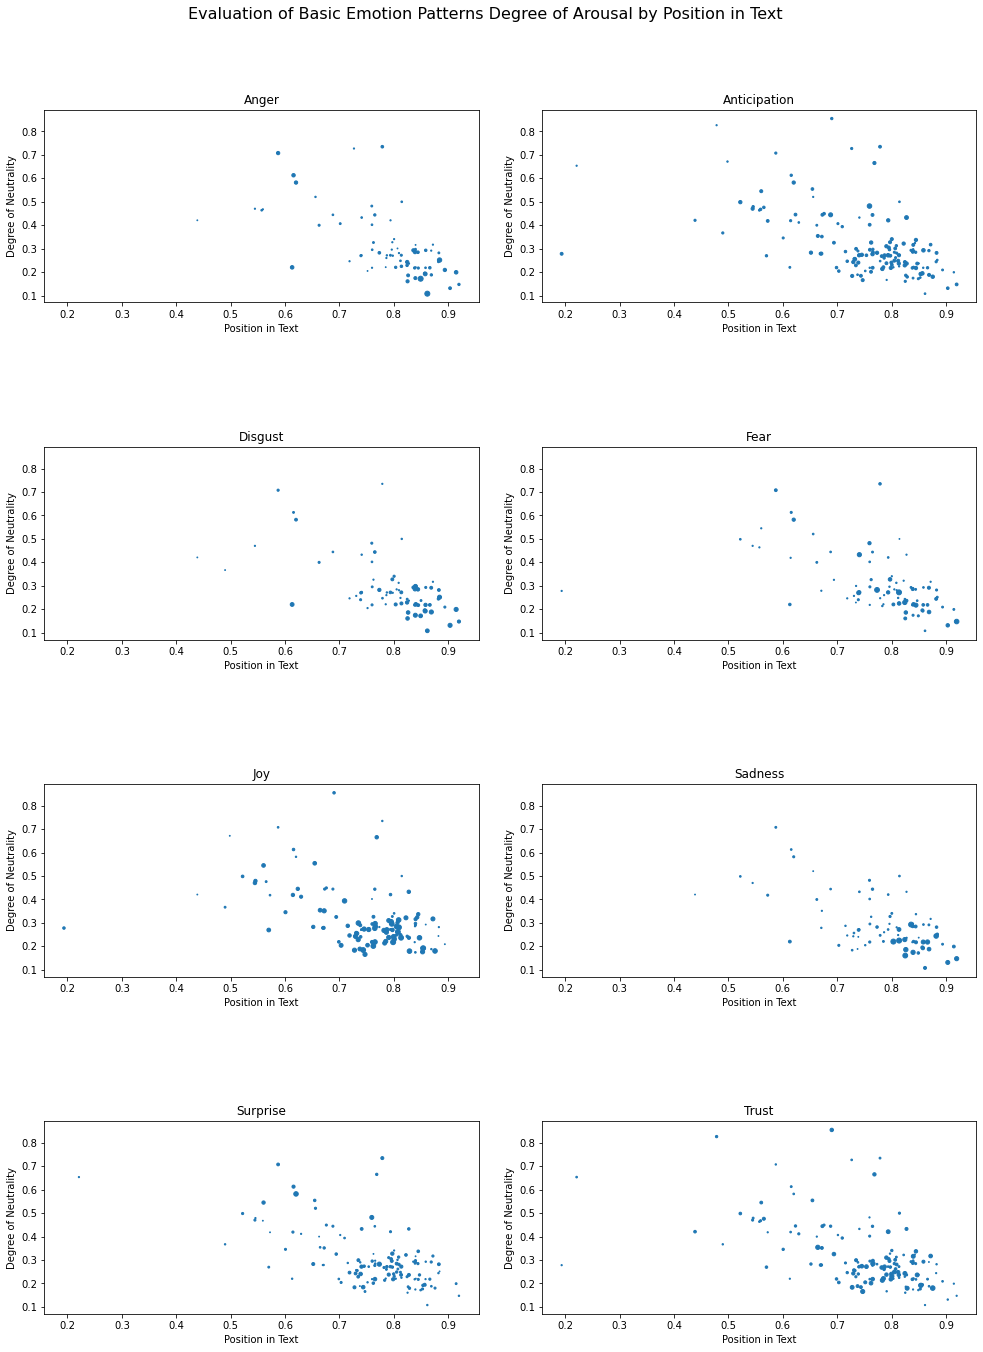

In [92]:
#Look at the data on plots using position in text compared to sentiment polarity

#Make a list of basic emotions
emotions = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]

#Define plot layout
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 8))

#Iterate over each emotion to define plot parameters
for emotion, ax in zip(emotions, axes.flatten()):
    x = df['Position'] 
    y = df['le_0']

    #Make marker size proportional to the degree of afinity to that emotion
    marker_size = df[emotion] * 25
    
    #Create the scatter plot
    ax.scatter(x, y, s=marker_size, alpha=1)

    #Set the title for each subplot
    ax.set_title(emotion.capitalize())

    #Add overall title
    fig.suptitle("Evaluation of Basic Emotion Patterns Degree of Arousal by Position in Text", fontsize=16)
    
    #Set axis labels
    ax.set_xlabel('Position in Text')
    ax.set_ylabel('Degree of Neutrality')

#Adjust spacing between subplots
plt.tight_layout()

#Define plot size
plt.gcf().set_size_inches(14, 20) 

#Display the plot
plt.show()

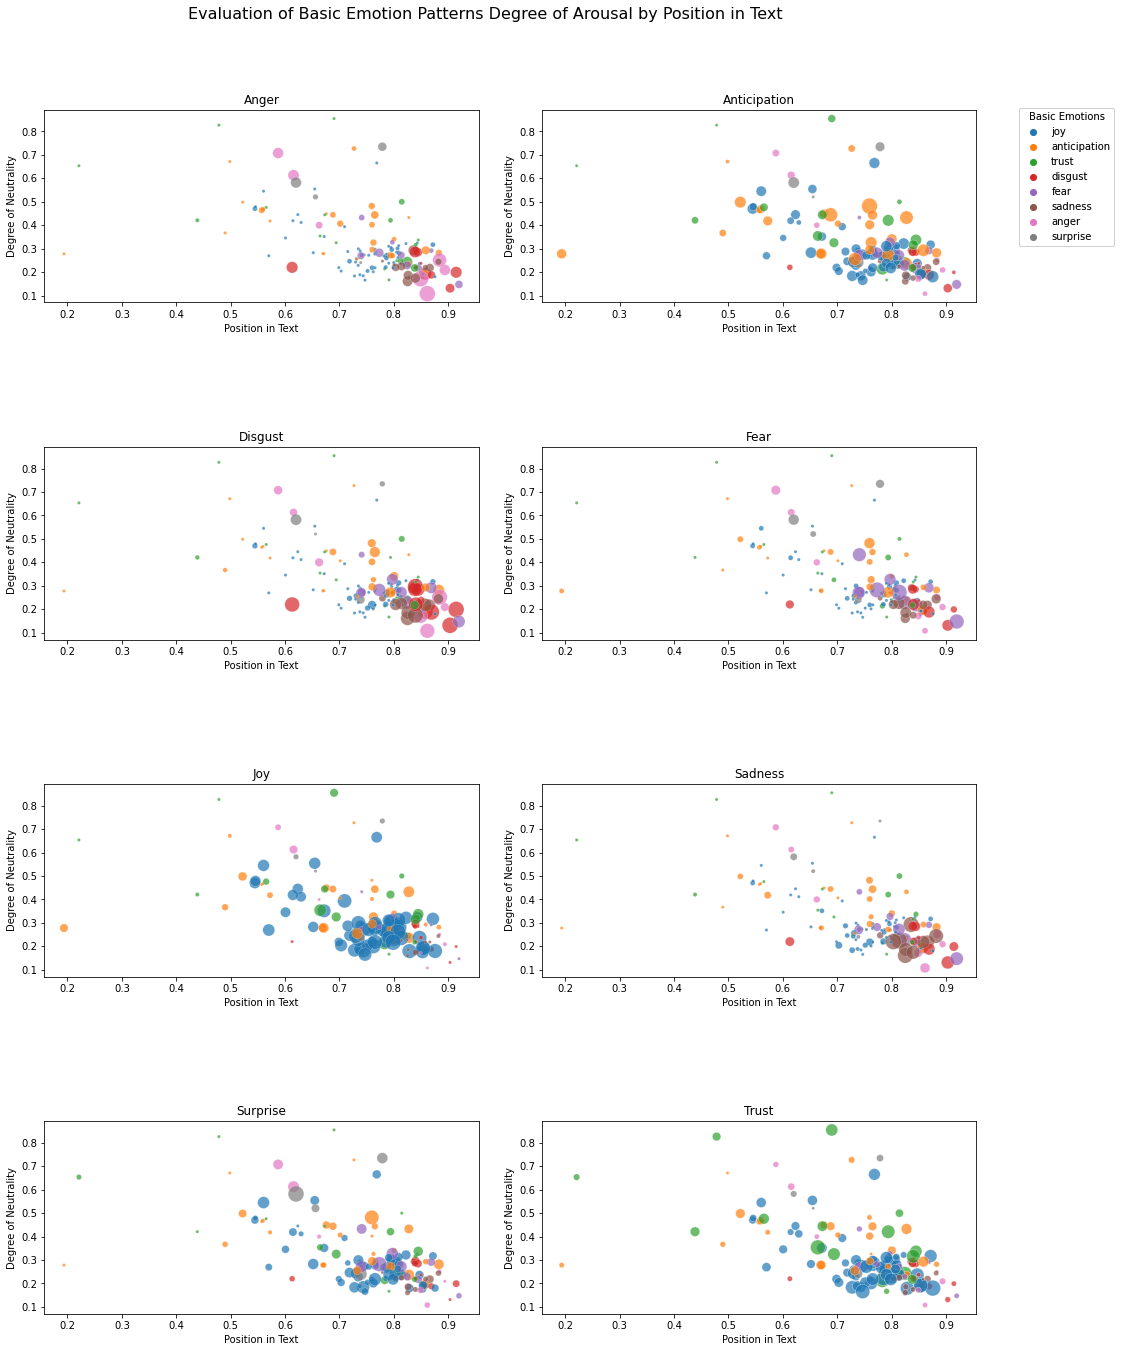

In [119]:
#Repeat plots adding a hue for the primary basic emotion
#Plot below will show the emotion with the greatest affinity to the emoji by colour
#The size of the marker represents the strength to which the basic emotion is being felt (per the plot title)
#Location on the plot 

#Make a list of basic emotions
emotions = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]

#Define plot layout
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 8))

#Lists to store legend handles and labels
legend_handles_color = []
legend_labels_color = []

#Iterate over each emotion to define plot parameters
for emotion, ax in zip(emotions, axes.flatten()):
    x = df['Position']
    y = df['le_0']

    #Make marker size proportional to the degree of affinity to that emotion
    marker_size = df[emotion] * 25

    #Create the scatter plot with hue as primary basic emotion
    sns.scatterplot(x=x, y=y, hue=df['primary_basic_emot'], size=marker_size, sizes=(10, 250), alpha=0.7, ax=ax)

    #Set the title for each subplot
    ax.set_title(emotion.capitalize())

    #Add overall title
    fig.suptitle("Evaluation of Basic Emotion Patterns Degree of Arousal by Position in Text", fontsize=16)

    #Set axis labels
    ax.set_xlabel('Position in Text')
    ax.set_ylabel('Degree of Neutrality')

    #Get the handles and labels for the color legend and add them to the lists
    handles_color, labels_color = ax.get_legend_handles_labels()
    legend_handles_color.extend(handles_color)
    legend_labels_color.extend(labels_color)

    #Remove size legend
    ax.get_legend().remove()

#Remove duplicates from the color legend
unique_handles_color, unique_labels_color = [], []
for handle_color, label_color in zip(legend_handles_color, legend_labels_color):
    if label_color in emotions and label_color not in unique_labels_color:  # Only include specified emotions in the legend
        unique_handles_color.append(handle_color)
        unique_labels_color.append(label_color)

#Create a custom color legend with only specified emotions labels
color_legend = fig.legend(handles=unique_handles_color, labels=unique_labels_color, bbox_to_anchor=(1.03, 0.91), loc='upper left', borderaxespad=0., title="Primary Basic Emotion")

#Add the color legend to the plot
fig.add_artist(color_legend)

#Adjust spacing between subplots
plt.tight_layout()

#Define plot size
plt.gcf().set_size_inches(14, 20)

#Display the plot
plt.show()

# Removal of zero probabilities

EDA on current data in addition to tests carried out to understand the impact of various smoothing parameters on the data in the relevant notebook has determined potential optimal smoothing methods and their ideal parameters for this work. This section will apply these to the data. Note that a number of different methods will be used initially as the consideration of their impacts on machine learning outcomes to predict information relating to emojis which are not represented by the basic theory dataset will be determined later. 

In [124]:
#Save dataframe as csv for use in other notebooks
df.to_csv("Combined_Emot_Data.csv", index=False)